In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
# Note: change your "path to folder" to the path connecting to your google drive mimic folder

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 880 kB 37.2 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 6.6 MB 32.8 MB/s 
     |████████████████████████████████| 596 kB 35.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=5b732e964ef49173b183cc9ba33d2e46369047fc423dae49ceea93f6196ceebe
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import re
import pandas as pd
import random
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import L1L2
import string
import logging
import random
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preprocessSHAC(dataFolder):
  rootFilePath = '/content/drive/MyDrive/"Relation Extraction"/Annotations/' + dataFolder + '/mimic'
  fileNames = !ls $rootFilePath
  textFiles = []
  annotationFiles = []
  for line in fileNames:
    for fileName in line.split():
      if fileName.endswith('.ann'):
        annotationFiles.append(fileName)
      elif fileName.endswith('.txt'):
        textFiles.append(fileName)

  textFiles = sorted(textFiles)
  annotationFiles = sorted(annotationFiles)
  dataFrameList = []
  for currentTextFileName in textFiles:
    print(currentTextFileName, end = " ")
    # currentTextFileName = '0301.txt'
    with open('/content/drive/MyDrive/Relation Extraction/Annotations/' + dataFolder + '/mimic/' + currentTextFileName, 'r') as text:
      currentPrefix = currentTextFileName.split('.')[0]
      currentAnnotationFile = ''
      for annFile in annotationFiles:
        if annFile.startswith(currentPrefix):
          currentAnnotationFile = annFile
          break
        
      with open('/content/drive/MyDrive/Relation Extraction/Annotations/' + dataFolder + '/mimic/' + currentAnnotationFile, 'r') as ann:
        rawTextData = text.read()
        rawAnnData = ann.read()
        if rawTextData.strip() != '' and rawAnnData.strip() != '' :
          cursor = 0
          annLines = rawAnnData.splitlines()
          triggers = {}
          events = {}
          values = {}
          for line in annLines:
            dataValues = line.strip().split()
            if dataValues[0].startswith("T"):
              start_pos = dataValues[2]
              end_pos = dataValues[3]
              trigger = ''
              trigerStartPos = 4
              if ';' in dataValues[3]:
                while ';' in dataValues[trigerStartPos]:
                  trigerStartPos += 1
                end_pos = dataValues[trigerStartPos]
                trigerStartPos += 1
              for idx in range(trigerStartPos, len(dataValues)):
                trigger += dataValues[idx]
                if idx != len(dataValues):
                  trigger += ' '
                
              triggers[dataValues[0]] = {
                  'start_pos': int(start_pos),
                  'end_pos': int(end_pos),
                  'trigger': trigger,
                  'type': dataValues[1]
              }
            elif dataValues[0].startswith("E"):
              eventSeq = []
              for idx in range(1,len(dataValues)):
                eventSeq.append({
                  'relationType': dataValues[idx].split(':')[0],
                  'triggerId': dataValues[idx].split(':')[1]
                })
              events[dataValues[0]] = eventSeq
            # elif dataValues[0].startswith("A"):
            
          defaultPositionCursorDistance = 15
          sentNum = 1
          sentenceInfoList = []
          cursor = 0
          sentenceList = sent_tokenize(rawTextData.replace('\n','/\/').replace('  ', ' |_|'))
          for sentence in sentenceList:
            sentence = sentence.replace('/\/', ' ').replace('|_|', ' ') 
            lim = len(sentence)
            if lim <= 0:
              continue
            if re.search('Social History:', sentence, re.IGNORECASE):
              sentence = re.split('Social History:', sentence, flags=re.IGNORECASE)[1]
              cursor += defaultPositionCursorDistance
              lim -= defaultPositionCursorDistance + 1
            # else:
            #   cursor += 1
            start_pos = cursor
            cursor += lim
            end_pos = cursor
            cursor += 1
            newSentenceInfo = {
                'start_pos': start_pos,
                'end_pos': end_pos,
                'sentence': sentence,
                'sentNum': sentNum
            }
            sentenceInfoList.append(newSentenceInfo)
            sentNum += 1
            # print(newSentenceInfo, lim, cursor)
          
          # print(sentenceInfoList)
          # print(events)
          # print(triggers)
          for event in events.keys():
            eventSeq = events[event]
            sentNum = -1
            sentence = None
            cursor = 0
            for sentenceInfo in sentenceInfoList:
              if (sentenceInfo['start_pos'] <= triggers[eventSeq[0]['triggerId']]['start_pos'] - 1) and (sentenceInfo['end_pos'] >= triggers[eventSeq[len(eventSeq) - 1]['triggerId']]['end_pos'] - 1):
                # print(sentenceInfo)
                sentNum = sentenceInfo['sentNum']
                sentence = sentenceInfo['sentence']
                cursor = sentenceInfo['start_pos']
                break
            newRowDefaults = {
                'sentence': sentence,
                'T1': triggers[eventSeq[0]['triggerId']]['trigger'],
                'T1_starting_postion': triggers[eventSeq[0]['triggerId']]['start_pos'] - cursor,
                'T1_ending_position': triggers[eventSeq[0]['triggerId']]['end_pos'] - cursor - 1,
                'T1_type': triggers[eventSeq[0]['triggerId']]['type'],
            }
            for idx  in range(1, len(eventSeq)):
              trigger = eventSeq[idx]
              newRow = {
                'id': currentPrefix+'_'+event+ sentence[slice(5)] if sentence != None else '',
              }
              newRow = {**newRow, **newRowDefaults}
              nextTrigger = {
                'T2': triggers[trigger['triggerId']]['trigger'],
                'T2_starting_postion': triggers[trigger['triggerId']]['start_pos'] - cursor,
                'T2_ending_position': triggers[trigger['triggerId']]['end_pos'] - cursor - 1,
                'T2_type': triggers[trigger['triggerId']]['type'],
                'relation_type': trigger['relationType'],
              }
              newRow = {**newRow, **nextTrigger}
              dataFrameList.append(newRow)
            
        ann.close()
      text.close()
  return pd.DataFrame(dataFrameList)

In [ ]:
trainDataSource = preprocessSHAC(dataFolder = 'train')
devDataSource = preprocessSHAC(dataFolder = 'dev')

0101.txt 0102.txt 0103.txt 0104.txt 0105.txt 0106.txt 0107.txt 0108.txt 0109.txt 0110.txt 0111.txt 0112.txt 0113.txt 0114.txt 0115.txt 0116.txt 0117.txt 0118.txt 0119.txt 0120.txt 0121.txt 0122.txt 0123.txt 0124.txt 0125.txt 0126.txt 0127.txt 0128.txt 0129.txt 0130.txt 0131.txt 0132.txt 0133.txt 0134.txt 0135.txt 0136.txt 0137.txt 0138.txt 0139.txt 0140.txt 0141.txt 0142.txt 0143.txt 0144.txt 0145.txt 0146.txt 0147.txt 0148.txt 0149.txt 0150.txt 0301.txt 0302.txt 0303.txt 0304.txt 0305.txt 0306.txt 0307.txt 0308.txt 0309.txt 0310.txt 0311.txt 0312.txt 0313.txt 0314.txt 0315.txt 0316.txt 0317.txt 0318.txt 0319.txt 0320.txt 0321.txt 0322.txt 0323.txt 0324.txt 0325.txt 0326.txt 0327.txt 0328.txt 0329.txt 0330.txt 0331.txt 0332.txt 0333.txt 0334.txt 0335.txt 0336.txt 0337.txt 0338.txt 0339.txt 0340.txt 0341.txt 0342.txt 0343.txt 0344.txt 0345.txt 0346.txt 0347.txt 0348.txt 0349.txt 0350.txt 0401.txt 0402.txt 0406.txt 0407.txt 0408.txt 0409.txt 0410.txt 0412.txt 0413.txt 0414.txt 0416.txt 0

In [ ]:
trainDataSource.shape

(10933, 11)

In [ ]:
devDataSource

,id,sentence,T1,T1_starting_postion,T1_ending_position,T1_type,T2,T2_starting_postion,T2_ending_position,T2_type,relation_type
0,0403_E1 Liv,Lives with his caring and devoted parents at...,Lives,2,6,LivingStatus,Lives,2,6,StatusTime,Status
1,0403_E1 Liv,Lives with his caring and devoted parents at...,Lives,2,6,LivingStatus,with his caring and devoted parents,8,42,TypeLiving,Type
2,0403_E2 No h,"No history of alcohol, tobacco or drug use.",tobacco,25,31,Tobacco,No history,2,11,StatusTime,Status
3,0403_E3 No h,"No history of alcohol, tobacco or drug use.",drug use,36,43,Drug,No history,2,11,StatusTime,Status
4,0403_E4 No h,"No history of alcohol, tobacco or drug use.",alcohol,16,22,Alcohol,No history,2,11,StatusTime,Status
...,...,...,...,...,...,...,...,...,...,...,...
1172,2916_E4 Live,"Lives with wife Retired Former tobacco use, s...",Alcohol,74,80,Alcohol,[**4-15**] drinks,83,99,Amount,Amount
1173,2916_E4 Live,"Lives with wife Retired Former tobacco use, s...",Alcohol,74,80,Alcohol,[**4-15**] drinks/week,83,104,StatusTime,Status
1174,2916_E4 Live,"Lives with wife Retired Former tobacco use, s...",Alcohol,74,80,Alcohol,/week,100,104,Frequency,Frequency
1175,2916_E5 Live,"Lives with wife Retired Former tobacco use, s...",recreational drug use,113,133,Drug,recreational,113,124,Type,Type


In [ ]:
trainDataSource.to_csv('trainDataset.csv')
devDataSource.to_csv('devDataset.csv')

In [ ]:
devDataSource.isna().sum()

id                     0
sentence               3
T1                     0
T1_starting_postion    0
T1_ending_position     0
T1_type                0
T2                     0
T2_starting_postion    0
T2_ending_position     0
T2_type                0
relation_type          0
dtype: int64

In [ ]:
trainDataSource.pivot_table(index=['relation_type', 'T2_type','T1_type'], aggfunc='count')

T1  T1_ending_position  \
relation_type T2_type      T1_type                                  
Amount        Amount       Alcohol        315                 315   
                           Drug            10                  10   
                           Tobacco        558                 558   
Amount2       Amount       Alcohol          7                   7   
                           Tobacco         27                  27   
Amount3       Amount       Tobacco          1                   1   
Duration      Duration     Alcohol         84                  84   
                           Drug            23                  23   
                           Employment      49                  49   
                           LivingStatus    37                  37   
                           Tobacco        296                 296   
Duration2     Duration     Alcohol          1                   1   
                           Tobacco          5                   5   
Frequency     Frequency    Alcohol        322                 322   
                           Drug            24                  24   
                           Tobacco        196                 196   
Frequency2    Frequency    Alcohol          4                   4   
History       History      Alcohol        147                 147   
                           Drug           100                 100   
                           Employment      49                  49   
                           LivingStatus    19                  19   
                           Tobacco        304                 304   
History2      History      Alcohol          1                   1   
Method        Method       Drug           193                 193   
                           Tobacco          5                   5   
Method2       Method       Drug             2                   2   
Status        StatusEmploy Employment     980                 980   
              StatusTime   Alcohol       1292                1292   
                           Drug           985                 985   
                           LivingStatus   959                 959   
                           Tobacco       1230                1230   
Status2       StatusEmploy Employment       1                   1   
              StatusTime   Alcohol          2                   2   
                           Drug             1                   1   
                           Tobacco          2                   2   
Type          Type         Alcohol        186                 186   
                           Drug           663                 663   
                           Employment     695                 695   
                           Tobacco        153                 153   
              TypeLiving   LivingStatus   959                 959   
Type2         Type         Alcohol          8                   8   
                           Drug            20                  20   
                           Employment      12                  12   
                           Tobacco          2                   2   
Type3         Type         Alcohol          1                   1   
                           Drug             2                   2   
                           Employment       1                   1   

                                         T1_starting_postion    T2  \
relation_type T2_type      T1_type                                   
Amount        Amount       Alcohol                       315   315   
                           Drug                           10    10   
                           Tobacco                       558   558   
Amount2       Amount       Alcohol                         7     7   
                           Tobacco                        27    27   
Amount3       Amount       Tobacco                         1     1   
Duration      Duration     Alcohol                        84    84   
                           Drug

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 1.2 MB 33.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=b17fa6dcf75bcfe4f0a2eb301e3aad8ffb6ec86f2f4cf54d051c89e075165312
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers


In [ ]:
cleanTrainDF = trainDataSource.dropna().reset_index()
cleanDevDF = devDataSource.dropna().reset_index()

In [ ]:
cleanTrainDF['fileName'] = cleanTrainDF['id'].apply(lambda x: x.split("_")[0])
cleanDevDF['fileName'] = cleanDevDF['id'].apply(lambda x: x.split("_")[0])

def splitDataSource(df, smallerSideMinimumPercentage):
  allFiles = df['fileName'].unique()
  testFiles = []
  while((df[df['fileName'].isin(testFiles)].shape[0] * 100/df.shape[0]) < smallerSideMinimumPercentage):
    randomChoice = random.choices(allFiles, k=1)
    while(randomChoice[0] in testFiles):
      randomChoice = random.choices(allFiles, k=1)
    testFiles.append(randomChoice[0])
  return testFiles

In [ ]:
for file in cleanTrainDF['fileName'].unique():
  if(file in cleanDevDF['fileName']):
    print(file, end = " ")

In [ ]:
cleanTrainDF['relation_type'].unique()

array(['Status', 'Amount', 'Frequency', 'Type', 'Method', 'Duration',
       'History', 'Type2', 'Type3', 'Amount2', 'Duration2', 'Frequency2',
       'Status2', 'History2', 'Amount3', 'Method2'], dtype=object)

In [ ]:
cleanTrainDF.shape

(10823, 13)

In [ ]:
from sentence_transformers import SentenceTransformer

def getDistilBertEmbeddings(df, feature_name = 'sentence'):
  model = SentenceTransformer('sentence-transformers/multi-qa-distilbert-cos-v1')
  return model.encode(df.reset_index()[feature_name])

In [ ]:
# !pip install spacy
# !pip install spacy_sentence_bert

In [ ]:
# ! pip install -U pip setuptools wheel
# ! pip install -U spacy
# ! python -m spacy download en_core_web_sm

In [ ]:
def getCorpus(sentences):
  nlp = spacy.load('en_core_web_sm')
  corpus = []
  for row in range(0, len(sentences)):
    str_tokens=[]
    tokens= nlp(sentences[row]).ents
    for i in range(0, len(tokens)):
      str_tokens.append(tokens[i].text)
    corpus.append(list(str_tokens))
  return corpus

def getSpacy_Word2Vec_Corpus(df):
  corpus=getCorpus(df.reset_index()['sentence'])
  return word2vec.Word2Vec(corpus, min_count=1, size=100)

In [ ]:
lemmatizer = WordNetLemmatizer()

def customtokenize(str):
    tokens=nltk.word_tokenize(str)
    ntokens = nltk.RegexpTokenizer(r"\w+")
    words = ntokens.tokenize(str)
    nostop = list(filter(lambda token: token not in stopwords.words('english'), words))
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

def getTFIDFMatrix(df):
  vectorizer = TfidfVectorizer(tokenizer=customtokenize)
  return vectorizer.fit_transform(df['sentence'])

In [ ]:
def getBagOfWords(df):
  CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
  Count_data = CountVec.fit_transform(df['sentence'])
  return pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())

In [ ]:
completeDF = pd.concat([cleanTrainDF, cleanDevDF])
testFiles = splitDataSource(completeDF, 30)
newTestDF = completeDF[completeDF['fileName'].isin(testFiles)]
newTrainDF = completeDF[~completeDF['fileName'].isin(testFiles)]
validFiles = splitDataSource(newTrainDF, 10)
newValidDF = newTrainDF[newTrainDF['fileName'].isin(validFiles)]
newTrainDF = newTrainDF[~newTrainDF['fileName'].isin(validFiles)]

In [ ]:
new_Train_BOW = getBagOfWords(newTrainDF)
new_Valid_BOW = getBagOfWords(newValidDF)
new_Test_BOW = getBagOfWords(newTestDF)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
new_Train_Spacy_Word2Vec = getSpacy_Word2Vec_Corpus(newTrainDF)
new_Valid_Spacy_Word2Vec = getSpacy_Word2Vec_Corpus(newValidDF)
new_Test_Spacy_Word2Vec = getSpacy_Word2Vec_Corpus(newTestDF)

In [ ]:
amountTrainDF = cleanTrainDF[(cleanTrainDF['relation_type'] == 'Amount')]
historyTrainDF = cleanTrainDF[(cleanTrainDF['relation_type'] == 'History')]

amountDevDF = cleanDevDF[(cleanDevDF['relation_type'] == 'Amount')]
historyDevDF = cleanDevDF[(cleanDevDF['relation_type'] == 'History')]

twoClassCleanTrainDF = pd.concat([amountTrainDF.sample(n=(min(amountTrainDF.shape[0], historyTrainDF.shape[0]))), historyTrainDF.sample(n=(min(amountTrainDF.shape[0], historyTrainDF.shape[0])))])
twoClassCleanDevDF = pd.concat([amountTrainDF.sample(n=(min(amountDevDF.shape[0], historyDevDF.shape[0]))), historyDevDF.sample(n=(min(amountDevDF.shape[0], historyDevDF.shape[0])))])

In [ ]:
# groupedByTarget = twoClassCleanTrainDF.groupby('relation_type')
# testDF = groupedByTarget.apply(lambda x: x.sample(groupedByTarget.size().min()).reset_index(drop=True))
# testDF.index.name='relation_group'
twoClassCleanTrainDF['relation_type'].value_counts()

Amount     592
History    592
Name: relation_type, dtype: int64

In [ ]:
# twoClassCleanTrainDF
# twoClassCleanDevDF
trainWord2Vec = getSpacy_Word2Vec_Corpus(twoClassCleanTrainDF)
testWord2Vec = getSpacy_Word2Vec_Corpus(twoClassCleanDevDF)

w2v_weights = trainWord2Vec.wv.vectors
vocab_size, embedding_size = w2v_weights.shape


In [ ]:
def word2token(word, w2v_model):
    try:
        return w2v_model.wv.vocab[word].index
    except KeyError:
        return 0
def token2word(token, w2v_model):
    return w2v_model.wv.index2word[token]

In [ ]:
import string
MAX_SEQUENCE_LENGTH = 50


class SequenceIterator:
    def __init__(self, dataset, seq_length, w2v_model, feature_name):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(dataset.relation_type, return_counts=True)
        
        self.seq_length = seq_length
        self.w2v_model = w2v_model
        self.feature_name = feature_name
        
    def __iter__(self):
        for news, cat in zip(self.dataset[self.feature_name], self.dataset.relation_type):
            # Make all characters lower-case
            news = news.lower()
            
            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w, self.w2v_model) for w in news.split(' ') if w != ''])
                                
            yield (words, cat)

def convertText2Feature(df, feature_name='sentence'):
  word2Vec = getSpacy_Word2Vec_Corpus(df)

  w2v_weights = word2Vec.wv.vectors
  vocab_size, embedding_size = w2v_weights.shape
  sequences = SequenceIterator(df, MAX_SEQUENCE_LENGTH, word2Vec, feature_name)

  # Used for generating the labels in the set
  cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}

  set_x = []
  set_y = []
  for w, c in sequences:
      set_x.append(w)
      set_y.append(cat_dict[c])
      
  # Padding sequences with 0.
  set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
  set_y = np.array(set_y)

  return cat_dict, set_x, set_y, w2v_weights, vocab_size, embedding_size

In [ ]:
cat_dict, test_x, test_y, w2v_weights, vocab_size, embedding_size = convertText2Feature(twoClassCleanDevDF)
cat_dict, set_x, set_y, w2v_weights, vocab_size, embedding_size = convertText2Feature(twoClassCleanTrainDF)

In [ ]:
VALID_PER = 0.15

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = set_x[random_i[:n_train]]
train_y = set_y[random_i[:n_train]]
val_x = set_x[random_i[n_train:n_train+n_val]]
val_y = set_y[random_i[n_train:n_train+n_val]]
categories, ccount = np.unique(train_y, return_counts=True)

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

n_categories = len(categories)

Train Shapes - X: (1007, 50) - Y: (1007,)
Val Shapes - X: (177, 50) - Y: (177,)


In [ ]:
values, counts = np.unique(train_y, return_counts=True)
print(values, counts)
values, counts = np.unique(val_y, return_counts=True)
print(values, counts)

[0 1] [499 508]
[0 1] [93 84]


In [ ]:
model = Sequential()
model.add(Dense(n_categories,
                activation='softmax',
                kernel_regularizer=L1L2(l1=0.0, l2=0.1),
                input_dim=train_x.shape[1]))
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
model.fit(train_x, train_y, epochs=100, validation_data=(val_x, val_y))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 1s 10ms/step - loss: 57.1160 - accuracy: 0.4717 - val_loss: 62.4981 - val_accuracy: 0.4294
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 44.5806 - accuracy: 0.5164 - val_loss: 42.2809 - val_accuracy: 0.4915
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 51.4555 - accuracy: 0.4786 - val_loss: 77.8959 - val_accuracy: 0.4350
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 49.4067 - accuracy: 0.5055 - val_loss: 51.8241 - val_accuracy: 0.4915
Epoch 5/100
3

In [ ]:
predicted_probs = model.predict(test_x)
preds = np.argmax(predicted_probs, axis=-1)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65        78
           1       0.64      0.46      0.54        78

    accuracy                           0.60       156
   macro avg       0.61      0.60      0.59       156
weighted avg       0.61      0.60      0.59       156



In [ ]:
gnb = MultinomialNB()
preds = gnb.fit(set_x, set_y).predict(test_x)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.56      0.60      0.58        78
           1       0.57      0.53      0.55        78

    accuracy                           0.56       156
   macro avg       0.56      0.56      0.56       156
weighted avg       0.56      0.56      0.56       156



In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model = DecisionTreeClassifier()
preds = model.fit(set_x, set_y).predict(test_x)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.46      0.51      0.48        78
           1       0.45      0.40      0.42        78

    accuracy                           0.46       156
   macro avg       0.45      0.46      0.45       156
weighted avg       0.45      0.46      0.45       156



In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()
preds = model.fit(set_x, set_y).predict(test_x)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.49      0.46      0.48        78
           1       0.49      0.53      0.51        78

    accuracy                           0.49       156
   macro avg       0.49      0.49      0.49       156
weighted avg       0.49      0.49      0.49       156



In [ ]:
from sklearn.svm import SVC
model = SVC(kernel="poly", degree=1, C=0.1, gamma=0.1)
preds = model.fit(set_x, set_y).predict(test_x)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.50      0.96      0.66        78
           1       0.40      0.03      0.05        78

    accuracy                           0.49       156
   macro avg       0.45      0.49      0.35       156
weighted avg       0.45      0.49      0.35       156



In [ ]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(100)))
model.add(Dense(n_categories, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=100, batch_size=64,
                    validation_data=(val_x, val_y), verbose=1)

Epoch 1/100
16/16 [==============================] - 15s 372ms/step - loss: 0.6931 - accuracy: 0.4965 - val_loss: 0.6930 - val_accuracy: 0.4802
Epoch 2/100
16/16 [==============================] - 2s 149ms/step - loss: 0.6919 - accuracy: 0.5869 - val_loss: 0.6907 - val_accuracy: 0.5763
Epoch 3/100
16/16 [==============================] - 2s 149ms/step - loss: 0.6899 - accuracy: 0.6058 - val_loss: 0.6904 - val_accuracy: 0.6158
Epoch 4/100
16/16 [==============================] - 2s 145ms/step - loss: 0.6869 - accuracy: 0.6167 - val_loss: 0.6891 - val_accuracy: 0.5932
Epoch 5/100
16/16 [==============================] - 2s 144ms/step - loss: 0.6821 - accuracy: 0.6276 - val_loss: 0.6924 - val_accuracy: 0.6158
Epoch 6/100
16/16 [==============================] - 2s 148ms/step - loss: 0.6761 - accuracy: 0.6276 - val_loss: 0.6990 - val_accuracy: 0.5593
Epoch 7/100
16/16 [==============================] - 2s 144ms/step - loss: 0.6732 - accuracy: 0.6246 - val_loss: 0.6952 - val_accuracy: 0.604

In [ ]:
predicted_probs = model.predict(test_x)
preds = np.argmax(predicted_probs, axis=-1)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.60      0.46      0.52        78
           1       0.56      0.69      0.62        78

    accuracy                           0.58       156
   macro avg       0.58      0.58      0.57       156
weighted avg       0.58      0.58      0.57       156



In [ ]:
!pip install gensim

In [ ]:
import gensim
def getText2Seq(corpus):
  lst_corpus = []
  for string in corpus:
      lst_words = string.split()
      lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                  len(lst_words), 1)]
      lst_corpus.append(lst_grams)
  bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
  bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
  trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
              delimiter=" ".encode(), min_count=5, threshold=10)
  trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)
      
  lst_corpus = list(bigrams_detector[lst_corpus])
  lst_corpus = list(trigrams_detector[lst_corpus])

  tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
  tokenizer.fit_on_texts(lst_corpus)
  dic_vocabulary = tokenizer.word_index

  lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

  return lst_corpus, kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
              padding="post", truncating="post"), dic_vocabulary
  


In [ ]:
w2vec_train_corpus, X_train_w2vec, dic_vocabulary_train_liar = getText2Seq(twoClassCleanTrainDF['sentence'])
w2vec_test_corpus, X_test_w2vec, dic_vocabulary_test_liar = getText2Seq(twoClassCleanDevDF['sentence'])

In [ ]:
nlp = gensim.models.word2vec.Word2Vec(w2vec_train_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [ ]:
embeddings = np.zeros((len(dic_vocabulary_train_liar)+1, 300))
for word,idx in dic_vocabulary_train_liar.items():
    try:
        embeddings[idx] =  nlp[word]
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
model = Sequential()
model.add(Dense(n_categories,
                activation='softmax',
                kernel_regularizer=L1L2(l1=0.0, l2=0.1),
                input_dim=X_train_w2vec.shape[1]))
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
model.fit(X_train_w2vec, set_y, epochs=100, validation_split=0.1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 1s 7ms/step - loss: 4325.5132 - accuracy: 0.5249 - val_loss: 5685.7236 - val_accuracy: 0.2353
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 4119.7285 - accuracy: 0.5305 - val_loss: 4361.1147 - val_accuracy: 0.4622
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 4653.6865 - accuracy: 0.5249 - val_loss: 552.0146 - val_accuracy: 0.9076
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 5172.7490 - accuracy: 0.5127 - val_loss: 17204.4531 - val_accuracy: 0.000

In [ ]:
predicted_probs = model.predict(X_test_w2vec)
preds = np.argmax(predicted_probs, axis=-1)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.52      0.64      0.57        78
           1       0.53      0.41      0.46        78

    accuracy                           0.53       156
   macro avg       0.53      0.53      0.52       156
weighted avg       0.53      0.53      0.52       156



In [ ]:
gnb = MultinomialNB()
preds = gnb.fit(X_train_w2vec, set_y).predict(X_test_w2vec)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.47      0.44      0.45        78
           1       0.47      0.50      0.48        78

    accuracy                           0.47       156
   macro avg       0.47      0.47      0.47       156
weighted avg       0.47      0.47      0.47       156



In [ ]:
model = DecisionTreeClassifier()
preds = model.fit(X_train_w2vec, set_y).predict(X_test_w2vec)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.55      0.65      0.60        78
           1       0.57      0.46      0.51        78

    accuracy                           0.56       156
   macro avg       0.56      0.56      0.55       156
weighted avg       0.56      0.56      0.55       156



In [ ]:
model = RandomForestClassifier()
preds = model.fit(X_train_w2vec, set_y).predict(X_test_w2vec)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.57      0.47      0.52        78
           1       0.55      0.64      0.59        78

    accuracy                           0.56       156
   macro avg       0.56      0.56      0.55       156
weighted avg       0.56      0.56      0.55       156



In [ ]:
from sklearn.svm import SVC
model = SVC(kernel="poly", degree=1, C=0.1, gamma=0.1)
preds = model.fit(X_train_w2vec, set_y).predict(X_test_w2vec)

In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67        78
           1       1.00      0.03      0.05        78

    accuracy                           0.51       156
   macro avg       0.75      0.51      0.36       156
weighted avg       0.75      0.51      0.36       156



In [ ]:
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

x_in = layers.Input(shape=(15,))
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
x = attention_layer(x, neurons=15)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 15, 300)      985500      ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 15)      0           ['embedding_1[0][0]']            
                                                                                                  
 dense_3 (Dense)                (None, 300, 15)      240         ['permute[0][0]']                
                                                                                              

In [ ]:
tf.config.run_functions_eagerly(True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


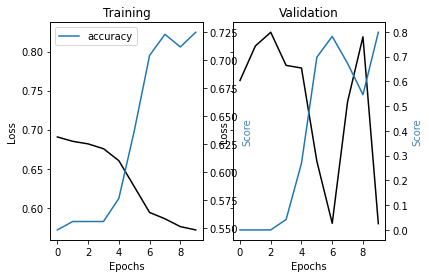

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(twoClassCleanTrainDF['relation_type'].values))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in twoClassCleanTrainDF['relation_type'].values])
## train
training = model.fit(x=X_train_w2vec, y=y_train, batch_size=128, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.1)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
predicted_prob = model.predict(X_test_w2vec)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy: 0.49
Detail:
              precision    recall  f1-score   support

      Amount       0.48      0.33      0.39        78
     History       0.49      0.64      0.56        78

    accuracy                           0.49       156
   macro avg       0.49      0.49      0.47       156
weighted avg       0.49      0.49      0.47       156



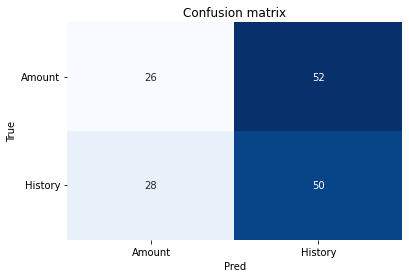

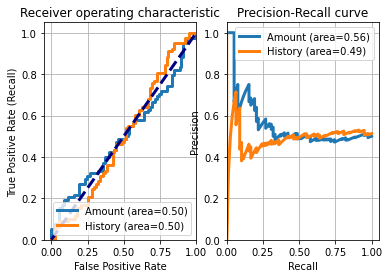

In [ ]:
from sklearn import metrics
y_test = twoClassCleanDevDF['relation_type'].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test_liar, predicted_prob, 
#                             multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [ ]:
cat_dict

{'Amount': 0, 'History': 1}

In [ ]:
trainBertEmbeddings = getDistilBertEmbeddings(twoClassCleanTrainDF)
testBertEmbeddings = getDistilBertEmbeddings(twoClassCleanDevDF)

trainBertY = twoClassCleanTrainDF['relation_type'].apply(lambda x: cat_dict[x]).values
testBertY = twoClassCleanDevDF['relation_type'].apply(lambda x: cat_dict[x]).values

train_x, val_x, train_y, val_y = train_test_split(trainBertEmbeddings, trainBertY, test_size=0.15, random_state=42)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
model = Sequential()
model.add(Dense(n_categories,
                activation='softmax',
                kernel_regularizer=L1L2(l1=0.0, l2=0.1),
                input_dim=train_x.shape[1]))
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
model.fit(trainBertEmbeddings, trainBertY, epochs=100, validation_data=(val_x, val_y))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2)                 1538      
                                                                 
Total params: 1,538
Trainable params: 1,538
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 1.1178 - accuracy: 0.4297

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


37/37 [==============================] - 1s 21ms/step - loss: 1.0867 - accuracy: 0.4375 - val_loss: 1.0574 - val_accuracy: 0.4157
Epoch 2/100
37/37 [==============================] - 1s 23ms/step - loss: 1.0303 - accuracy: 0.4434 - val_loss: 1.0045 - val_accuracy: 0.4157
Epoch 3/100
37/37 [==============================] - 1s 21ms/step - loss: 0.9818 - accuracy: 0.4561 - val_loss: 0.9592 - val_accuracy: 0.4719
Epoch 4/100
37/37 [==============================] - 1s 22ms/step - loss: 0.9400 - accuracy: 0.4873 - val_loss: 0.9204 - val_accuracy: 0.5169
Epoch 5/100
37/37 [==============================] - 1s 18ms/step - loss: 0.9042 - accuracy: 0.5279 - val_loss: 0.8870 - val_accuracy: 0.5337
Epoch 6/100
37/37 [==============================] - 1s 18ms/step - loss: 0.8733 - accuracy: 0.5701 - val_loss: 0.8584 - val_accuracy: 0.5955
Epoch 7/100
37/37 [==============================] - 1s 21ms/step - loss: 0.8467 - accuracy: 0.6047 - val_loss: 0.8338 - val_accuracy: 0.6348
Epoch 8/100
37/37 

In [ ]:
predicted_probs = model.predict(testBertEmbeddings)
preds = np.argmax(predicted_probs, axis=-1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
print(metrics.classification_report(testBertY, preds))

              precision    recall  f1-score   support

           0       0.77      0.62      0.69        78
           1       0.68      0.82      0.74        78

    accuracy                           0.72       156
   macro avg       0.73      0.72      0.71       156
weighted avg       0.73      0.72      0.71       156



In [ ]:
# from sklearn.decomposition import NMF
# nmf = NMF(init='random', random_state=0)
# gnb = MultinomialNB()
# preds = gnb.fit(trainBertEmbeddings, trainBertY).predict(testBertEmbeddings)

In [ ]:
# print(metrics.classification_report(testBertY, preds))

In [ ]:
model = DecisionTreeClassifier()
preds = model.fit(trainBertEmbeddings, trainBertY).predict(testBertEmbeddings)

In [ ]:
print(metrics.classification_report(testBertY, preds))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71        78
           1       0.72      0.62      0.66        78

    accuracy                           0.69       156
   macro avg       0.69      0.69      0.68       156
weighted avg       0.69      0.69      0.68       156



In [ ]:
model = RandomForestClassifier()
preds = model.fit(trainBertEmbeddings, trainBertY).predict(testBertEmbeddings)

In [ ]:
print(metrics.classification_report(testBertY, preds))

              precision    recall  f1-score   support

           0       0.80      0.68      0.74        78
           1       0.72      0.83      0.77        78

    accuracy                           0.76       156
   macro avg       0.76      0.76      0.75       156
weighted avg       0.76      0.76      0.75       156



In [ ]:
from sklearn.svm import SVC
model = SVC(kernel="poly", degree=1, C=0.1, gamma=0.1)
preds = model.fit(trainBertEmbeddings, trainBertY).predict(testBertEmbeddings)

In [ ]:
print(metrics.classification_report(testBertY, preds))

              precision    recall  f1-score   support

           0       0.81      0.45      0.58        78
           1       0.62      0.90      0.73        78

    accuracy                           0.67       156
   macro avg       0.72      0.67      0.66       156
weighted avg       0.72      0.67      0.66       156



In [ ]:
bertModel = Sequential()
input_dim, output_dim = trainBertEmbeddings.shape

# Keras Embedding layer with Word2Vec weights initialization
bertModel.add(Embedding(input_dim=input_dim,
                    output_dim=output_dim,
                    input_length=768,
                    mask_zero=True,
                    trainable=False))

bertModel.add(Bidirectional(LSTM(100)))
bertModel.add(Dense(n_categories, activation='softmax'))

bertModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bertModel.fit(train_x, train_y, epochs=20, batch_size=64,
                    validation_data=(val_x, val_y), verbose=1)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


16/16 [==============================] - 326s 20s/step - loss: 0.7072 - accuracy: 0.5020 - val_loss: 0.6962 - val_accuracy: 0.4551
Epoch 2/20
16/16 [==============================] - 346s 22s/step - loss: 0.6960 - accuracy: 0.4940 - val_loss: 0.7067 - val_accuracy: 0.4551
Epoch 3/20
16/16 [==============================] - 354s 22s/step - loss: 0.6952 - accuracy: 0.5119 - val_loss: 0.6912 - val_accuracy: 0.5449
Epoch 4/20
16/16 [==============================] - 392s 25s/step - loss: 0.6948 - accuracy: 0.4920 - val_loss: 0.6949 - val_accuracy: 0.4551
Epoch 5/20
16/16 [==============================] - 350s 22s/step - loss: 0.6969 - accuracy: 0.5080 - val_loss: 0.6946 - val_accuracy: 0.4551
Epoch 6/20
16/16 [==============================] - 366s 23s/step - loss: 0.6938 - accuracy: 0.4821 - val_loss: 0.6950 - val_accuracy: 0.4551
Epoch 7/20
16/16 [==============================] - 368s 23s/step - loss: 0.6933 - accuracy: 0.5080 - val_loss: 0.6938 - val_accuracy: 0.4551
Epoch 8/20
16/16 

In [ ]:
predicted_probs = bertModel.predict(testBertEmbeddings)
preds = np.argmax(predicted_probs, axis=-1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
print(metrics.classification_report(testBertY, preds))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        78
           1       0.00      0.00      0.00        78

    accuracy                           0.50       156
   macro avg       0.25      0.50      0.33       156
weighted avg       0.25      0.50      0.33       156



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cat_dict, test_x, test_y, w2v_weights, vocab_size, embedding_size = convertText2Feature(twoClassCleanDevDF)
cat_dict, set_x, set_y, w2v_weights, vocab_size, embedding_size = convertText2Feature(twoClassCleanTrainDF)

cat_dict, set_x_t1, set_y, w2v_weights_t1, vocab_size_t1, embedding_size_t1 = convertText2Feature(twoClassCleanTrainDF, 'T1')
cat_dict, set_x_t2, set_y, w2v_weights_t2, vocab_size_t2, embedding_size_t2 = convertText2Feature(twoClassCleanTrainDF, 'T2')

VALID_PER = 0.15

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = set_x[random_i[:n_train]]
train_x_t1 = set_x_t1[random_i[:n_train]]
train_x_t2 = set_x_t2[random_i[:n_train]]
train_y = set_y[random_i[:n_train]]
val_x = set_x[random_i[n_train:n_train+n_val]]
val_x_t1 = set_x_t1[random_i[n_train:n_train+n_val]]
val_x_t2 = set_x_t2[random_i[n_train:n_train+n_val]]
val_y = set_y[random_i[n_train:n_train+n_val]]
categories, ccount = np.unique(train_y, return_counts=True)

n_categories = len(categories)

In [ ]:
print(train_x.shape)
print(train_x_t1.shape)
print(train_x_t2.shape)
print(w2v_weights.shape)
print(w2v_weights_t1.shape)
print(w2v_weights_t2.shape)
print(train_y.shape)
print(vocab_size)

(1007, 50)
(1007, 50)
(1007, 50)
(994, 100)
(994, 100)
(994, 100)
(1007,)
994


In [ ]:
# Keras Embedding layer with Word2Vec weights initialization
sentenceInput = Input(shape=(MAX_SEQUENCE_LENGTH,))
sentenceInputEmbedding = Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False)(sentenceInput)

t1Input = Input(shape=(MAX_SEQUENCE_LENGTH,))
t1InputEmbedding = Embedding(input_dim=vocab_size_t1,
                    output_dim=embedding_size_t1,
                    weights=[w2v_weights_t1],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False)(t1Input)

t2Input = Input(shape=(MAX_SEQUENCE_LENGTH,))
t2InputEmbedding = Embedding(input_dim=vocab_size_t2,
                    output_dim=embedding_size_t2,
                    weights=[w2v_weights_t2],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False)(t2Input)

embeddingInput = tf.keras.layers.Concatenate(axis=1)([sentenceInputEmbedding, t1InputEmbedding, t2InputEmbedding])

lstm = (Bidirectional(LSTM(100)))(embeddingInput)
output = Dense(n_categories, activation='softmax')(lstm)
model = Model(inputs=[sentenceInput, t1Input, t2Input], outputs=[output])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 50, 100)      99400       ['input_2[0][0]']                
                                                                                            

In [ ]:
history = model.fit([train_x, train_x_t1, train_x_t2], train_y, epochs=200, batch_size=64,
                    validation_data=([val_x, val_x_t1, val_x_t2], val_y), verbose=1)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


16/16 [==============================] - 48s 3s/step - loss: 0.6923 - accuracy: 0.5084 - val_loss: 0.6940 - val_accuracy: 0.4463
Epoch 2/200
16/16 [==============================] - 45s 3s/step - loss: 0.6897 - accuracy: 0.5094 - val_loss: 0.6903 - val_accuracy: 0.4463
Epoch 3/200
16/16 [==============================] - 45s 3s/step - loss: 0.6849 - accuracy: 0.5263 - val_loss: 0.6779 - val_accuracy: 0.5537
Epoch 4/200
16/16 [==============================] - 48s 3s/step - loss: 0.6737 - accuracy: 0.6048 - val_loss: 0.6518 - val_accuracy: 0.6441
Epoch 5/200
16/16 [==============================] - 45s 3s/step - loss: 0.6716 - accuracy: 0.6137 - val_loss: 0.6329 - val_accuracy: 0.6384
Epoch 6/200
16/16 [==============================] - 47s 3s/step - loss: 0.6685 - accuracy: 0.6177 - val_loss: 0.6516 - val_accuracy: 0.6328
Epoch 7/200
16/16 [==============================] - 46s 3s/step - loss: 0.6615 - accuracy: 0.6097 - val_loss: 0.6400 - val_accuracy: 0.6384
Epoch 8/200
16/16 [======

In [ ]:
cat_dict, test_x_t1, test_y, _, _ ,_ = convertText2Feature(twoClassCleanDevDF, 'T1')
cat_dict, test_x_t2, test_y, _, _ ,_ = convertText2Feature(twoClassCleanDevDF, 'T2')

In [ ]:
predicted_probs = model.predict([test_x, test_x_t1, test_x_t2])
preds = np.argmax(predicted_probs, axis=-1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
print(metrics.classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.50      0.71      0.59        78
           1       0.51      0.31      0.38        78

    accuracy                           0.51       156
   macro avg       0.51      0.51      0.49       156
weighted avg       0.51      0.51      0.49       156



In [ ]:
print(metrics.confusion_matrix(test_y, preds))

[[55 23]
 [54 24]]


In [ ]:
trainBertEmbeddings_sentence = getDistilBertEmbeddings(twoClassCleanTrainDF)
testBertEmbeddings_sentence = getDistilBertEmbeddings(twoClassCleanDevDF)

trainBertEmbeddings_T1 = getDistilBertEmbeddings(twoClassCleanTrainDF, 'T1')
testBertEmbeddings_T1 = getDistilBertEmbeddings(twoClassCleanDevDF, 'T1')

trainBertEmbeddings_T2 = getDistilBertEmbeddings(twoClassCleanTrainDF, 'T2')
testBertEmbeddings_T2 = getDistilBertEmbeddings(twoClassCleanDevDF, 'T2')

trainBertY = twoClassCleanTrainDF['relation_type'].apply(lambda x: cat_dict[x]).values
testBertY = twoClassCleanDevDF['relation_type'].apply(lambda x: cat_dict[x]).values

In [ ]:
print(trainBertEmbeddings_sentence.shape)
print(testBertEmbeddings_sentence.shape)
print(trainBertEmbeddings_T1.shape)
print(testBertEmbeddings_T1.shape)
print(trainBertEmbeddings_T2.shape)
print(testBertEmbeddings_T2.shape)

(1184, 768)
(156, 768)
(1184, 768)
(156, 768)
(1184, 768)
(156, 768)


In [ ]:
train_x, val_x, train_y, val_y = train_test_split(
    np.append(np.append(trainBertEmbeddings_sentence, trainBertEmbeddings_T1, axis=1), trainBertEmbeddings_T2, axis=1), 
    trainBertY, 
    test_size=0.15, random_state=42)

In [ ]:
bertModel = Sequential()
input_dim, output_dim = trainBertEmbeddings.shape

# Keras Embedding layer with Word2Vec weights initialization
bertModel.add(Embedding(input_dim=input_dim,
                    output_dim=output_dim,
                    input_length=3 * 768,
                    mask_zero=True,
                    trainable=False))

bertModel.add(Bidirectional(LSTM(100)))
bertModel.add(Dense(n_categories, activation='softmax'))

bertModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bertModel.fit(train_x, train_y, epochs=10, batch_size=128,
                    validation_data=(val_x, val_y), verbose=1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


8/8 [==============================] - 776s 97s/step - loss: 0.7052 - accuracy: 0.4920 - val_loss: 0.6891 - val_accuracy: 0.5449
Epoch 2/10
8/8 [==============================] - 755s 96s/step - loss: 0.6962 - accuracy: 0.4980 - val_loss: 0.7014 - val_accuracy: 0.4551
Epoch 3/10
8/8 [==============================] - 706s 89s/step - loss: 0.6941 - accuracy: 0.5080 - val_loss: 0.6947 - val_accuracy: 0.4551
Epoch 4/10
8/8 [==============================] - 710s 90s/step - loss: 0.6944 - accuracy: 0.4980 - val_loss: 0.6908 - val_accuracy: 0.5449
Epoch 5/10
8/8 [==============================] - 810s 104s/step - loss: 0.6933 - accuracy: 0.5119 - val_loss: 0.7026 - val_accuracy: 0.4551
Epoch 6/10
5/8 [=================>............] - ETA: 4:25 - loss: 0.6961 - accuracy: 0.5031

In [ ]:
predicted_probs = bertModel.predict(np.append(np.append(testBertEmbeddings_sentence, testBertEmbeddings_T1, axis=1), testBertEmbeddings_T2, axis=1))
preds = np.argmax(predicted_probs, axis=-1)

In [ ]:
print(metrics.classification_report(testBertY, preds))

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased',
                                                       do_lower_case=True, is_split_into_words = False)

def getFeatureEmbeddingBert(corpus):
  maxlen = 50

  maxqnans = np.int((maxlen-20)/2)
  corpus_tokenized = ["[CLS] "+
              " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
              str(txt).lower().strip()))[:maxqnans])+
              " [SEP]" for txt in corpus]

  masks = [[1]*len(txt.split()) + [0]*(maxlen - len(
            txt.split())) for txt in corpus_tokenized]

  
  txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split())) if len(txt.split()) != maxlen
             else txt for txt in corpus_tokenized]
      
  idx = tokenizer(txt2seq, truncation=True, padding=True, max_length = maxlen)
  idx = idx['input_ids']

  segments = [] 
  for seq in txt2seq:
      temp, i = [], 0
      for token in seq.split():
          temp.append(i)
          if token == "[SEP]":
              i += 1
      segments.append(temp)
  return [np.asarray(idx, dtype='int32'), 
            np.asarray(masks, dtype='int32'), 
            np.asarray(segments, dtype='int32')]

X_train_Bert = getFeatureEmbeddingBert(twoClassCleanTrainDF['sentence'].dropna())
X_test_Bert = getFeatureEmbeddingBert(twoClassCleanDevDF['sentence'].dropna())

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [ ]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
segments = layers.Input((50), dtype="int32", name="input_segments")
## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased")
bert_out = nlp([idx, masks, segments])
print(bert_out.keys())
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out['last_hidden_state'])
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(trainBertY)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks, segments], y_out)
for layer in model.layers[:4]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


odict_keys(['last_hidden_state', 'pooler_output'])
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 input_segments (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_idx[0][0]',              
                                thPooling

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


17/17 [==============================] - 718s 42s/step - loss: 0.7114 - accuracy: 0.5408 - val_loss: 0.7502 - val_accuracy: 0.4370


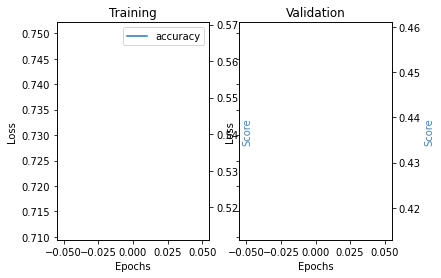

In [ ]:
## train
training = model.fit(x=X_train_Bert, y=trainBertY, batch_size=64, 
                     epochs=1, shuffle=True, verbose=1, 
                     validation_split=0.1)

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()
## test
predicted_prob = model.predict(X_test_Bert)
predicted = [np.argmax(pred) for pred in 
             predicted_prob]

Accuracy: 0.55
Detail:
              precision    recall  f1-score   support

           0       0.54      0.77      0.63        78
           1       0.59      0.33      0.43        78

    accuracy                           0.55       156
   macro avg       0.56      0.55      0.53       156
weighted avg       0.56      0.55      0.53       156



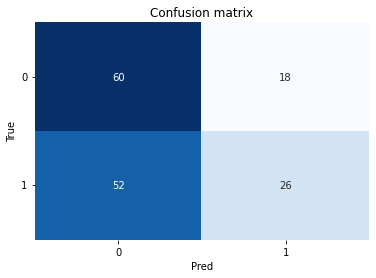

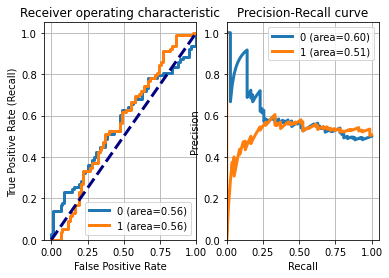

In [ ]:
from sklearn import metrics
classes = np.unique(testBertY)
y_test_array = pd.get_dummies(testBertY, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(testBertY, predicted)
# auc = metrics.roc_auc_score(y_test_liar, predicted_prob, 
#                             multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(testBertY, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(testBertY, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()